**Data Engineer exercises**
- Date: 9/16/2020
- Purpose: Sample ETL exercise with constituent data.


<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

## Auxiliary code to structure notebook

HTML code to left align markdown tables

In [1]:
%%html
<style>
table {float:left}
</style>

javascript code to fill Table of Contents

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Question 1
**Produce a “people” file with the following schema. Save it as a CSV with a header line to the working directory.**

    
| Column | Type | Description |
| :-- | :-- | :-- |
|email | string | Primary email address | 
|code | string | Source code |
|is_unsub | boolean | If primary email address is unsubscribed |
|created_dt | datetime | Person creation datetime |
|updated_dt | datetime | Person updated datetime |



## Question 2
**Use the output of #1 to produce an “acquisition_facts” file with the following schema that aggregates stats about when people in the dataset were acquired. Save it to the working directory.**

| Column | Type | Description | 
| :-- | :-- | :-- |
| acquisition_date | date | Calendar date of acquisition | 
| acquisitions | int | Number of constituents acquired on acquisition date |

# Method notes
This section contains notes on the methodologies used in the ETL.

## Data frame notes

The following dataframes are used to reference the respective Constituent data.

1. `df_info` : [Constituent Information](https://als-hiring.s3.amazonaws.com/fake_data/2020-07-01_17%3A11%3A00/cons.csv)
2. `df_email` : [Constituent Email Addresses](https://als-hiring.s3.amazonaws.com/fake_data/2020-07-01_17%3A11%3A00/cons_email.csv)
3. `df_subs` : [Constituent Subscription Status](https://als-hiring.s3.amazonaws.com/fake_data/2020-07-01_17%3A11%3A00/cons_email_chapter_subscription.csv)


## Data sources
This section details the data sources for the different output files generated.

### People file data source

This section details which dataframe is used to gather the data output in the persons file:

| Column | Type | Description | Dataframe source | 
| :-- | :-- | :-- | :-- |
|email | string | Primary email address | `df_emails.email` |
|code | string | Source code | `df_info.source` |
|is_unsub | boolean | If primary email address is unsubscribed | `df_subs.is_unsub` |
|created_dt | datetime | Person creation datetime | `df_info.create_dt` |
|updated_dt | datetime | Person updated datetime | `df_info.modified_dt` |



### Acquisition facts data source
Data source for the acquisition data file

| Column | Type | Description | Data source |
| :-- | :-- | :-- | :-- |
| acquisition_date | date | Calendar date of acquisition | Date extracted from `created_dt` from people file | 
| acquisitions | int | Number of constituents acquired on acquisition date | Count() extracted from number of emails on `created_dt` |

## Keep relevant columns
To increase notebook performance and readability, I only keep columns that are relevant to the ETL exercise.

Based on the questions outlined in this exercise and the columns identified in [Identify relevant information & entity relationships](#identify-relevant-information-&-entity-relationships), I am interested in the following columns for each dataframe:


**df_info:**
- `cons_id`: primary key, relates to other columns
- `source`: code string data for q1 table
- `create_dt`: created_dt datetime data for q1 table
- `modified_dt`: updated_dt datetime for q1 table

**df_emails:**
- `cons_email_id`: primary key
- `cons_id`: foreign key used to link to df_info
- `email`: email string data for q1 table

**df_subs:**
- `cons_email_chapter_subscription_id`: primary key
- `cons_email_id`: foreign key to link to df_emails
- `isunsub`: is_unsub boolean data for q1 table

## Relational joins
The three data files contain relational data with contain primary and foreign keys to connect information about users. Relational joins are required to retrieve the information for the people file.

I use `df_emails` as the base data file because it contains the most user records.
Left joins to the df_emails table are made to preserve email addresses. This is based on the assumption that email addresses are the variable of interest.

Given df_emails, the following left joins can be made:
- `df_emails.cons_email_id` = `df_subs.cons_email_id`
- `df_emails.cons_id` = `df_info.cons_id`

*NOTE*: Because I used a left_join, it's possible that there will be NULL values in merged columns.

## Handling missing data
The script handles missing data based on the intent of the data. 

Questions 1 and 2 are interested in the following data:
1. `email`
1. `code`
1. `is_unsub`
1. `created_dt`
1. `updated_dt`

`email` is the unique identifier for each row and used to count constituents 'acquired'. Additionally, I use the variable `create_dt` from the constituent information file to record acquisition dates. Because `email` is a primary key and `create_dt` is used to create the acquisition_facts.csv, I will drop records with NULL values in these fields.

The folloiwng data: `code`, `is_unsub`, and `updated_dt` are descriptive information about the constituent. This data is not necessary for the acquisition_facts output for question 2. As such, missing data in these columns will be filled witht he string "unknown".

## Duplicate values
Because `email` is the primary key used in the csv outputs, I remove all duplicates.

## Duplicate foreign keys
In exploratory analysis, I discovered that there are duplicate foriegn keys in `df_emails` and `df_subs`.

### df_emails.cons_id
First, there are duplicate foreign keys in `df_emails.cons_id`. It *is* a possibility that `df_emails.cons_id` to `df_info.cons_id` is a one to many relationship, although unlikely due to there being two datetimes values in each row. 

**Note**: Because 86% of `df_emails` contains duplicate foreign keys, I opt to keep the the duplicates of `df_emails.cons_id` rather than lose valuable data. **This decision will affect the acquisition_facts.csv output**. In the case that the duplicate `df_emails.cons_id` foreign keys _should_ be removed, I left a commented function to remove the duplicate keys.


### df_subs.cons_email_ids
Additionally, there are duplicate foreign keys in `df_subs.cons_email_ids`. For this ETL, I remove the rows with duplicate `cons_email_ids` foreign keys. I remove the duplicate keys to avoid erroneously providing incorrect information on the `inunsub` status of Constituents. Sending emails to unsubscribed Constituents may run into legal issues under the CAN-SPAM Act. 

*Note*: further analysis may explore if rows with duplicate `cons_email_id` contain identical information (i.e., `isunsub`). If so, analysis can keep one instance of each duplicate.

# Libraries

In [3]:
import os
import re
from typing import List, Tuple, Union

## Uncomment below code to install 3rd party libraries
# missingno used to identify missing data
# pywrangle is an open-source library I am developing for data cleaning
# ! pip install pandas
# ! pip install matplotlib
# ! pip install numpy
# ! pip install seaborn
# ! pip install missingno
# ! pip install pywrangle  

import pandas as pd
pd.plotting.register_matplotlib_converters()
pd.options.mode.chained_assignment = None  # default='warn'  Disables false positive warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import missingno as msno
import pywrangle as pw

header = '#' * 10
print('\n', header, "# Loaded libraries", header, sep = '\n')



##########
# Loaded libraries
##########


# Import data

The following 3 data sources are used:

1. [Constituent Information](https://als-hiring.s3.amazonaws.com/fake_data/2020-07-01_17%3A11%3A00/cons.csv)
2. [Constituent Email Addresses](https://als-hiring.s3.amazonaws.com/fake_data/2020-07-01_17%3A11%3A00/cons_email.csv)
3. [Constituent Subscription Status](https://als-hiring.s3.amazonaws.com/fake_data/2020-07-01_17%3A11%3A00/cons_email_chapter_subscription.csv)

*Note*: Boolean columns (including is_primary) in all of these datasets are 1/0 numeric values. 1 means True, 0 means False.

In [4]:
## Urls to download csvs
url_info_csv = 'https://als-hiring.s3.amazonaws.com/fake_data/2020-07-01_17%3A11%3A00/cons.csv'
url_email_csv = 'https://als-hiring.s3.amazonaws.com/fake_data/2020-07-01_17%3A11%3A00/cons_email.csv'
url_sub_csv = 'https://als-hiring.s3.amazonaws.com/fake_data/2020-07-01_17%3A11%3A00/cons_email_chapter_subscription.csv'

url_csvs = (
    url_info_csv,
    url_email_csv,
    url_sub_csv
)

## Csv file names
csv_datafiles = (
    'cons.csv',      ## info
    'cons_email.csv',                      
    'cons_email_chapter_subscription.csv'   
)

In [5]:
def load_df(filename_csv: str, url_csv: str) -> object:
    """Auxiliary function to load csvs into dataframe.
    
    Checks if csv exists in working directory. 
    If not, downloads csv from url.
    """
    file_path = f'./{filename_csv}'
    
    print('\n', '#' * 5, ' ',  filename_csv, sep = '')
    if os.path.isfile(file_path):
        print("Reading from working directory.")
        df = pd.read_csv(filename_csv)
    
    else:
        print("Loading data from url. This is a large file, so please be patient.")
        df = pd.read_csv(url_csv)
        
        print(f"\tSaving {filename_csv} to working directory.")
        df.to_csv(path_or_buf = filename_csv)
    
    print(f"""Loaded df for {filename_csv}:
    - {len(df.columns)} columns
    - {len(df)} rows""")
    return df


In [6]:
## Load all csvs

df_info, df_emails, df_subs = (
    load_df(csv_datafiles[i], url_csvs[i]) for i in range(len(csv_datafiles))
)

print("\nLoaded all csv data.")


##### cons.csv
Reading from working directory.
Loaded df for cons.csv:
    - 30 columns
    - 700000 rows

##### cons_email.csv
Loading data from url. This is a large file, so please be patient.
	Saving cons_email.csv to working directory.
Loaded df for cons_email.csv:
    - 16 columns
    - 1400000 rows

##### cons_email_chapter_subscription.csv
Loading data from url. This is a large file, so please be patient.
	Saving cons_email_chapter_subscription.csv to working directory.
Loaded df for cons_email_chapter_subscription.csv:
    - 6 columns
    - 350000 rows

Loaded all csv data.


# Data cleaning

## Face check data
This section does a face check of the data to look at the contents of each dataframe.


In [7]:
df_info.head()

,Unnamed: 0,cons_id,prefix,firstname,middlename,lastname,suffix,salutation,gender,birth_dt,...,change_password_next_login,consent_type_id,create_dt,create_app,create_user,modified_dt,modified_app,modified_user,status,note
0,0,1,NaN,NaN,Lee,NaN,MD,NaN,E,NaN,...,0,5958,"Fri, 1983-08-26 06:02:03",1484,6162,"Sun, 2015-12-27 09:28:02",4022,6349,1,NaN
1,1,2,NaN,NaN,NaN,NaN,II,boFqBKgLlSgEZsFrgCZd,E,"Mon, 2004-11-15",...,1,4236,"Mon, 1979-03-05 21:08:54",4176,5476,"Tue, 1989-06-20 13:28:57",9010,5698,1,NaN
2,2,3,NaN,NaN,David,King,NaN,NaN,D,"Fri, 1994-04-08",...,1,1263,"Fri, 2008-08-22 19:20:28",4702,8239,"Fri, 2020-06-05 18:13:57",8837,1175,1,NaN
3,3,4,Ms.,Mark,Gregg,NaN,NaN,NaN,J,NaN,...,0,949,"Sun, 1984-04-29 11:18:18",7096,7875,"Tue, 2012-01-31 07:26:35",7529,3984,1,NaN
4,4,5,NaN,NaN,Logan,NaN,DDS,ArvPJuEozHPaqbirovMi,D,"Sun, 2008-08-10",...,0,7126,"Thu, 2007-07-19 18:28:09",706,5727,"Tue, 1971-04-27 06:53:53",9356,6062,1,NaN


In [8]:
df_emails.head()

,cons_email_id,cons_id,cons_email_type_id,is_primary,email,canonical_local_part,domain,double_validation,create_dt,create_app,create_user,modified_dt,modified_app,modified_user,status,note
0,1,548198,3361,1,xmartinez@vincent.com,NaN,gmail.com,NaN,"Wed, 1994-01-26 23:49:16",4072,9954,"Sat, 2014-04-19 19:10:39",1990,7595,1,NaN
1,2,491137,2474,1,hmiller@haynes.biz,jqCyozTDojYuylQPTHfm,hotmail.com,NaN,"Thu, 1999-12-09 06:18:27",1600,5716,"Sat, 1984-07-14 05:55:27",4686,3248,1,NaN
2,3,413429,5175,1,aaron64@yahoo.com,FCBeBiVoqnnKDWjnllhN,yahoo.com,kRLZexQEwYIMbwFNvQxg,"Wed, 1992-11-18 16:46:27",7358,2685,"Sun, 1995-12-24 13:13:01",3857,7405,1,NaN
3,4,347346,4117,1,wyattvincent@hotmail.com,NaN,gmail.com,zSbfmlqXimGyWVBUGdQg,"Sat, 1983-11-26 16:49:14",881,3444,"Sun, 1975-01-19 14:32:56",8713,7713,1,NaN
4,5,443000,6781,1,tspencer@hotmail.com,VaQIYlKcUkIywkKKEptD,gmail.com,NaN,"Wed, 2000-11-15 13:28:34",5380,5456,"Sun, 1994-03-13 16:38:37",765,8618,1,NaN


In [9]:
df_subs.head()

,cons_email_chapter_subscription_id,cons_email_id,chapter_id,isunsub,unsub_dt,modified_dt
0,1,332188,1,1,"Sat, 1971-06-12 15:38:44","Thu, 1990-06-28 10:54:20"
1,2,536526,1,1,"Wed, 2006-07-12 01:50:45","Thu, 1979-09-20 06:02:35"
2,3,134711,1,1,"Tue, 1987-01-06 13:05:15","Sun, 1974-03-03 15:11:50"
3,4,660345,1,1,"Sat, 2016-08-06 11:06:09","Wed, 1995-09-13 23:45:03"
4,5,184268,1,1,"Sun, 2000-05-28 02:20:45","Sat, 1983-12-10 08:09:58"


## Identify relevant information & entity relationships
This section looks at the schema of each dataframe, identifies relevant columns for the ETL exercise, and primary/foreign keys to connect data frame results.

In [10]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 30 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  700000 non-null  int64  
 1   cons_id                     700000 non-null  int64  
 2   prefix                      350304 non-null  object 
 3   firstname                   350244 non-null  object 
 4   middlename                  560213 non-null  object 
 5   lastname                    349314 non-null  object 
 6   suffix                      349541 non-null  object 
 7   salutation                  350021 non-null  object 
 8   gender                      349891 non-null  object 
 9   birth_dt                    349954 non-null  object 
 10  title                       350082 non-null  object 
 11  employer                    349228 non-null  object 
 12  occupation                  350239 non-null  object 
 13  income        

Relevant columns in **df_info**:
- `cons_id`: primary key, relates to other columns
- `source`: code string data for q1 table
- `create_dt`: created_dt datetime data for q1 table
- `modified_dt`: updated_dt datetime for q1 table

In [11]:
df_emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 16 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   cons_email_id         1400000 non-null  int64 
 1   cons_id               1400000 non-null  int64 
 2   cons_email_type_id    1400000 non-null  int64 
 3   is_primary            1400000 non-null  int64 
 4   email                 1400000 non-null  object
 5   canonical_local_part  700029 non-null   object
 6   domain                1400000 non-null  object
 7   double_validation     699825 non-null   object
 8   create_dt             1400000 non-null  object
 9   create_app            1400000 non-null  int64 
 10  create_user           1400000 non-null  int64 
 11  modified_dt           1400000 non-null  object
 12  modified_app          1400000 non-null  int64 
 13  modified_user         1400000 non-null  int64 
 14  status                1400000 non-null  int64 
 15

Relevant columns in **df_emails**:
- `cons_email_id`: primary key
- `cons_id`: foreign key used to link to df_info
- `email`: email string data for q1 table

*NOTE:*
There are two unclear elements in this table.
- `create_dt`: unclear if this may also fulfill q1 table requirement.
- `modified_dt`: unclear if this may also fulfill q1 table requirement

However, because these are associated in the email information, I will assume that the `create_dt` and `modified_dt` is used for the email, and not the person. As such, I will use the `create_dt` and `modified_dt` in df_info.

In [12]:
df_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350000 entries, 0 to 349999
Data columns (total 6 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   cons_email_chapter_subscription_id  350000 non-null  int64 
 1   cons_email_id                       350000 non-null  int64 
 2   chapter_id                          350000 non-null  int64 
 3   isunsub                             350000 non-null  int64 
 4   unsub_dt                            350000 non-null  object
 5   modified_dt                         350000 non-null  object
dtypes: int64(4), object(2)
memory usage: 16.0+ MB


Relevant columns in **df_subs**:
- `cons_email_chapter_subscription_id`: primary key
- `cons_email_id`: foreign key to link to df_emails
- `isunsub`: is_unsub boolean data for q1 table

#### Entity relationship notes
The three data files contain relational data with contain primary and foreign keys to connect information about users. Relational joins are required to retrieve the information for the people file.

I use `df_emails` as the base data file because it contains the most user records.
Left joins to the df_emails table are made to preserve email addresses. This is based on the assumption that email addresses are the variable of interest.

Given df_emails, the following left joins can be made:
- `df_emails.cons_email_id` = `df_subs.cons_email_id`
- `df_emails.cons_id` = `df_info.cons_id`

*NOTE*: Because I used a left_join, it's possible that there will be NULL values in merged columns.


## Keep relevant columns
To increase notebook performance and readability, I only keep columns that are relevant to the analysis.

Based on the questions outlined in this exercise and the columns identified in [Identify relevant information & entity relationships](#identify-relevant-information-&-entity-relationships), I am interested in the following columns for each dataframe:


**df_info:**
- `cons_id`: primary key, relates to other columns
- `source`: code string data for q1 table
- `create_dt`: created_dt datetime data for q1 table
- `modified_dt`: updated_dt datetime for q1 table

**df_emails:**
- `cons_email_id`: primary key
- `cons_id`: foreign key used to link to df_info
- `email`: email string data for q1 table

**df_subs:**
- `cons_email_chapter_subscription_id`: primary key
- `cons_email_id`: foreign key to link to df_emails
- `isunsub`: is_unsub boolean data for q1 table

In [13]:
## columns to save for each df
cols_df_info = [
    'cons_id',
    'source',
    'create_dt',
    'modified_dt'
]
cols_df_email = [
    'cons_email_id',
    'cons_id',
    'email',
#     'create_dt',
#     'modified_dt',
]
cols_df_subs = [
    'cons_email_chapter_subscription_id',
    'cons_email_id',
    'isunsub'
]


In [14]:
## Auxilary function to modify df and track changes
def keep_df_cols(df: object, columns: list) -> object:
    """Returns pandas dataframe with only specified columns.
    
    Uses pywrangle to document df changes."""
    df_old = pw.record_df_info(df)
    df = df[columns]
    pw.print_df_changes(df, df_old)
    return df


In [15]:
## Keep information columns
df_info = keep_df_cols(df_info, cols_df_info)
df_info.head()

df       	num rows  	num columns  	df.size    	
--       	--------  	-----------  	-------    	
before   	700000    	30           	21000000   	
after    	700000    	4            	2800000    	
df diff  	0         	-26          	-18200000  	
% diff   	0.0%      	-86.67%      	-86.67%    	



,cons_id,source,create_dt,modified_dt
0,1,google,"Fri, 1983-08-26 06:02:03","Sun, 2015-12-27 09:28:02"
1,2,facebook,"Mon, 1979-03-05 21:08:54","Tue, 1989-06-20 13:28:57"
2,3,NaN,"Fri, 2008-08-22 19:20:28","Fri, 2020-06-05 18:13:57"
3,4,google,"Sun, 1984-04-29 11:18:18","Tue, 2012-01-31 07:26:35"
4,5,NaN,"Thu, 2007-07-19 18:28:09","Tue, 1971-04-27 06:53:53"


Drop 25 columns from `df_info` and 86% of the data.

In [16]:
## Keep email columns
df_emails = keep_df_cols(df_emails, cols_df_email)
df_emails.head()

df       	num rows  	num columns  	df.size    	
--       	--------  	-----------  	-------    	
before   	1400000   	16           	22400000   	
after    	1400000   	3            	4200000    	
df diff  	0         	-13          	-18200000  	
% diff   	0.0%      	-81.25%      	-81.25%    	



,cons_email_id,cons_id,email
0,1,548198,xmartinez@vincent.com
1,2,491137,hmiller@haynes.biz
2,3,413429,aaron64@yahoo.com
3,4,347346,wyattvincent@hotmail.com
4,5,443000,tspencer@hotmail.com


Drop 13 columns from `df_emails` and 81% of the data.

In [17]:
## Keep subscription columns
df_subs = keep_df_cols(df_subs, cols_df_subs)
df_subs.head()

df       	num rows  	num columns  	df.size   	
--       	--------  	-----------  	-------   	
before   	350000    	6            	2100000   	
after    	350000    	3            	1050000   	
df diff  	0         	-3           	-1050000  	
% diff   	0.0%      	-50.0%       	-50.0%    	



,cons_email_chapter_subscription_id,cons_email_id,isunsub
0,1,332188,1
1,2,536526,1
2,3,134711,1
3,4,660345,1
4,5,184268,1


Drop 3 columns from `df_subs` and 50% of the data.

## Missing data
Look at the missing data in each dataframe.

In [18]:
def check_df_missing_data(df: object, df_name: str) -> None:
    """Creates msno.bar graph of data present in dataframe."""
    msno.bar(df)
    plt.title(f"Non-NULL values for {df_name} data.")
    plt.xlabel("Column")
    plt.ylabel("% data present")
    plt.figure(figsize=(5, 2))

### Missing constituent info data

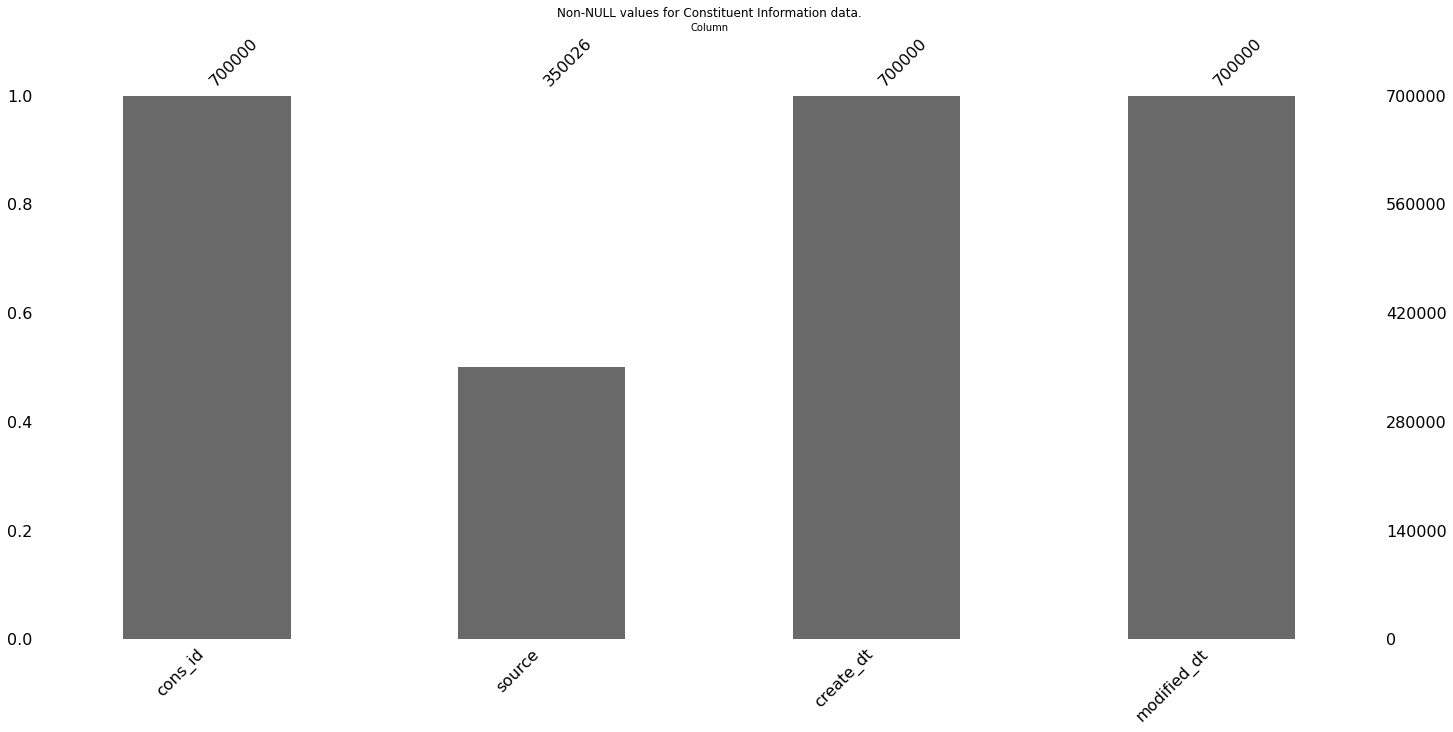

<Figure size 360x144 with 0 Axes>

In [19]:
check_df_missing_data(df_info, "Constituent Information")

NOTE: There `source` column is missing approximately half of its data. Because there is still relevant information on for `create_dt` and `modified_dt`, I will keep missing data in the source columns,

In [20]:
df_info['source'].value_counts()

organic     87875
google      87614
twitter     87510
facebook    87027
Name: source, dtype: int64

Source data is categorical with 4 categories:
- organic
- google
- twitter
- facebook

Because about half of source values are NULL, I will preserve them and label them as `unknown`.

In [21]:
df_info['source'].fillna("unknown", inplace = True)

Check NULLs are transformed

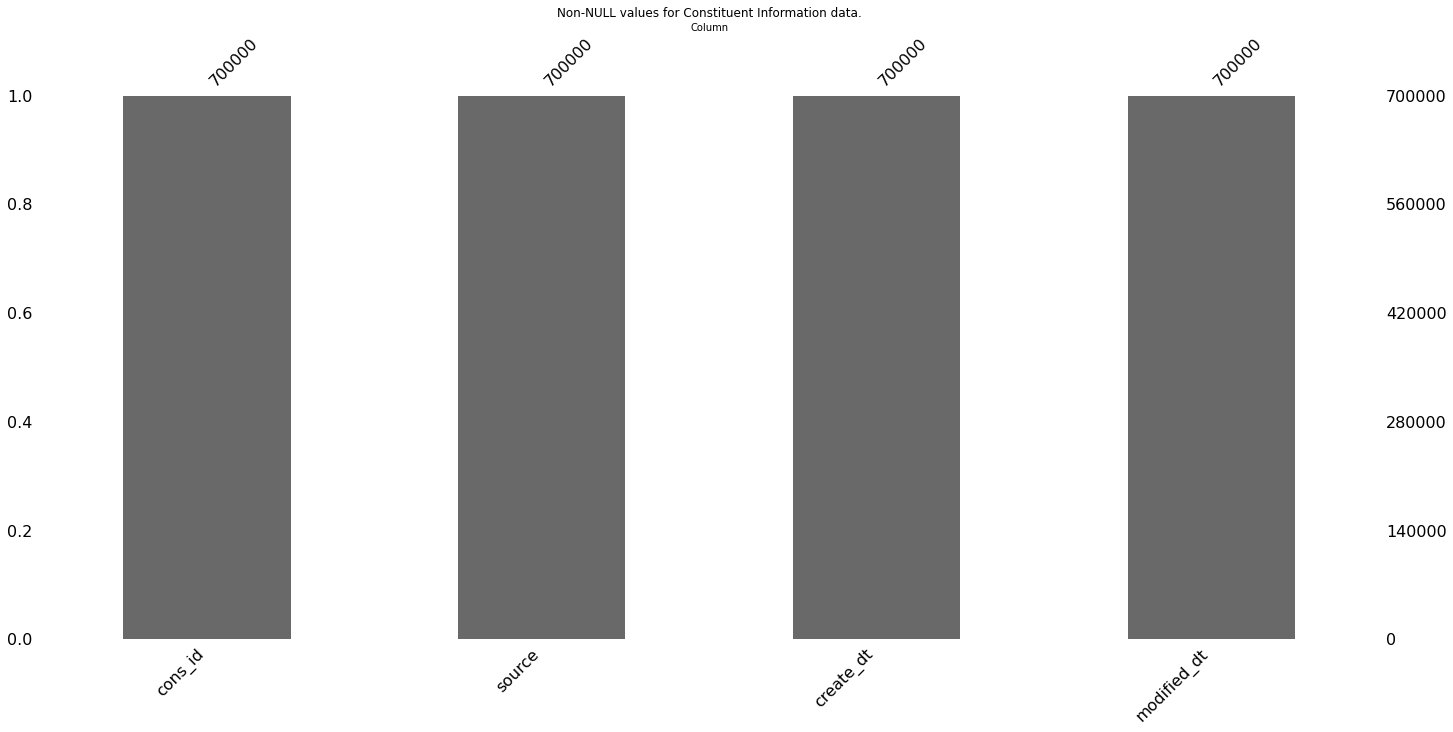

<Figure size 360x144 with 0 Axes>

In [22]:
check_df_missing_data(df_info, "Constituent Information")

In [23]:
df_info['source'].value_counts()

unknown     349974
organic      87875
google       87614
twitter      87510
facebook     87027
Name: source, dtype: int64

### Missing email data

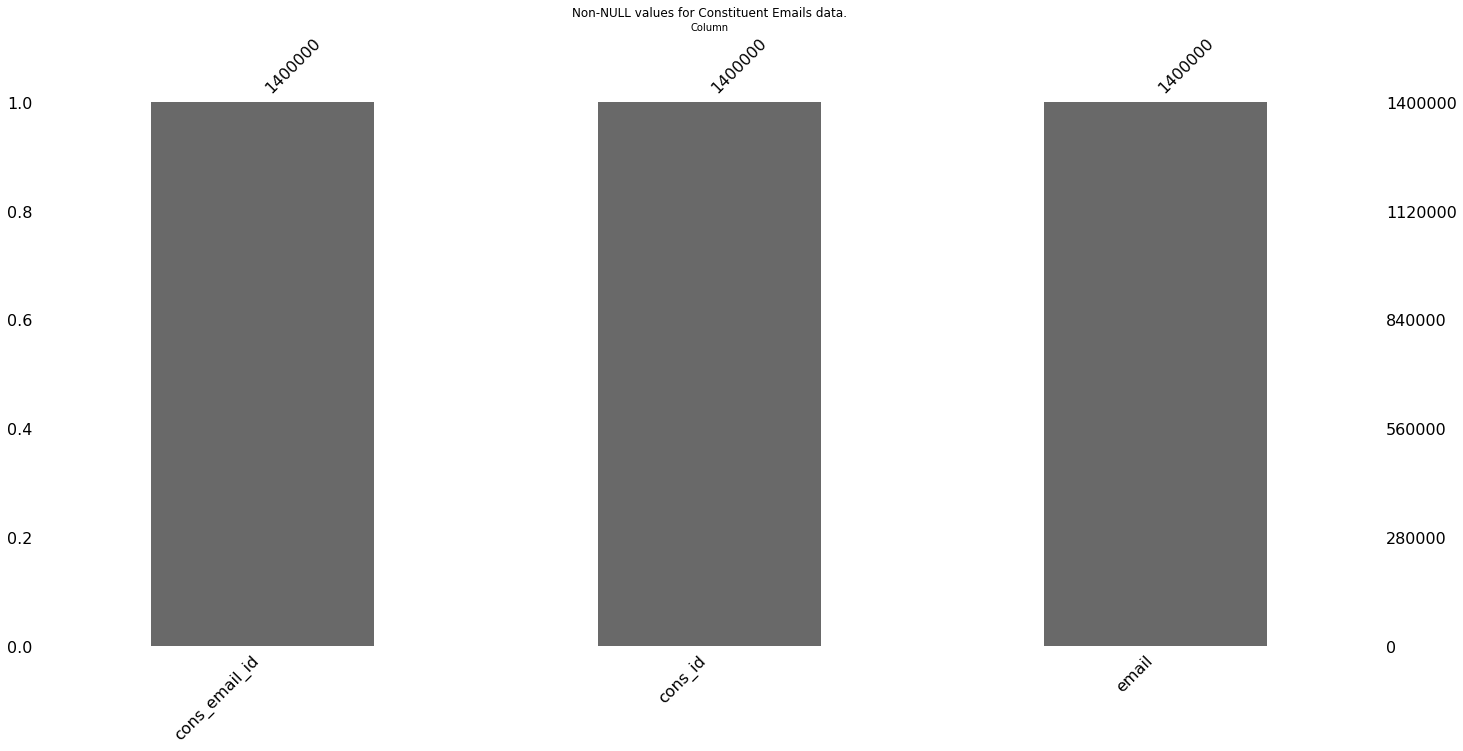

<Figure size 360x144 with 0 Axes>

In [24]:
check_df_missing_data(df_emails, "Constituent Emails")

No missing values in `df_emails`

### Missing subscription data

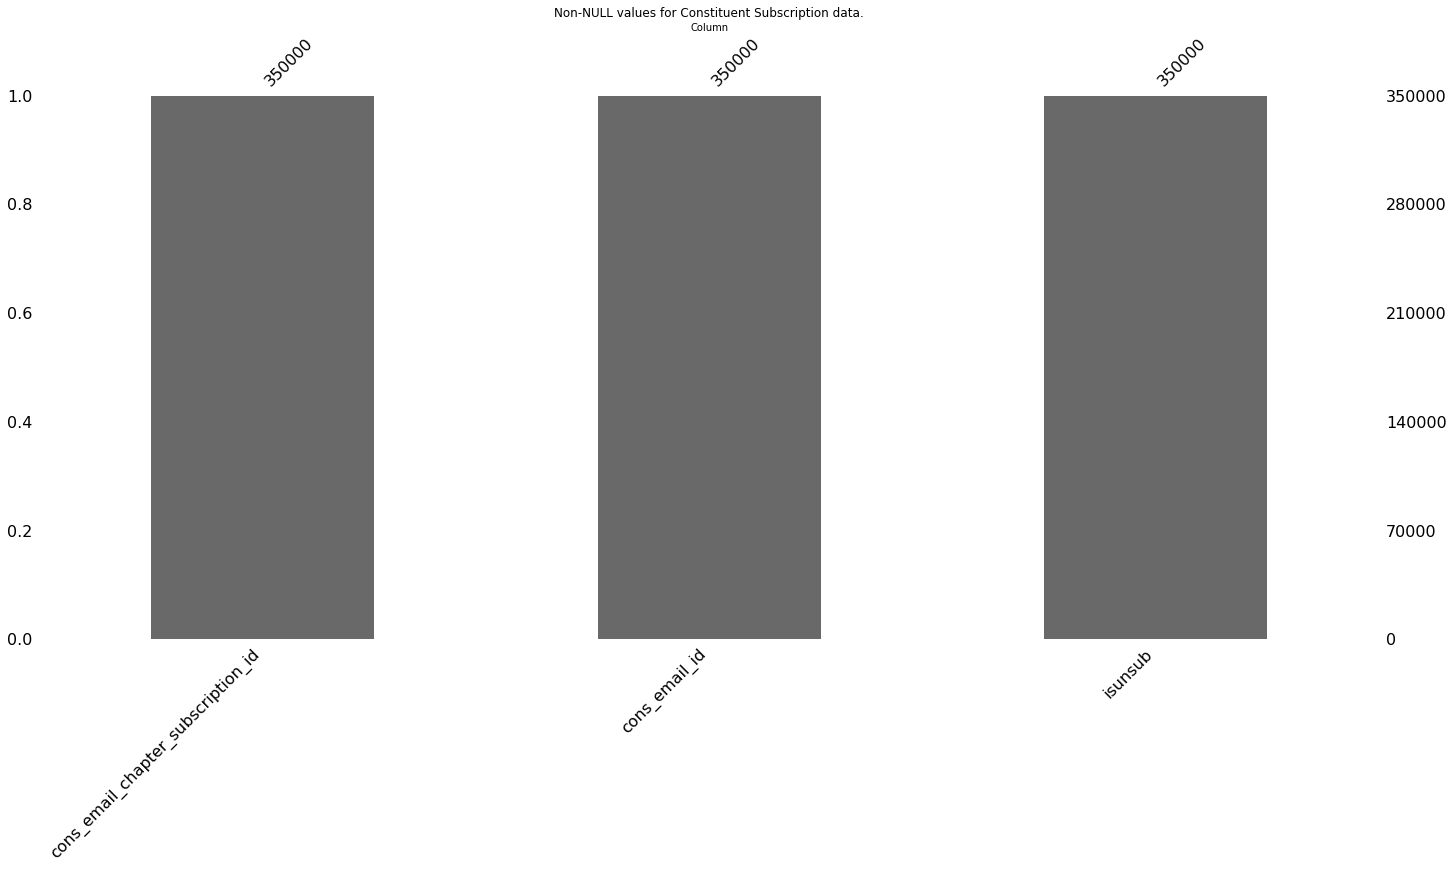

<Figure size 360x144 with 0 Axes>

In [25]:
check_df_missing_data(df_subs, "Constituent Subscription")

No missing values in `df_subs`.

## Clean string data
This section cleans string data in the data frame columns.

All strings are lower cased in the column for consistency purposes.

### Standardize constituent information
Use pywrangle to standardize string column casing. Pass a tuple of tuples containing a string indicating the column to clean, and an integer representing the cleaning method to use.

In [26]:
cons_info_strcol_caseint: Tuple[Tuple[ str, int]] = (
    ("source", 0),
    ("create_dt", 0),
    ("modified_dt", 0)
)
df_info = pw.clean_str_columns( df_info, cons_info_strcol_caseint)

Column		Str Cleaning
------		------------
source 		lower
create_dt		lower
modified_dt		lower



### Standardize emails

In [27]:
cons_email_strcol_caseint: Tuple[Tuple[ str, int]] = (
    ('email', 0),
)
df_emails = pw.clean_str_columns( df_emails, cons_email_strcol_caseint)

Column		Str Cleaning
------		------------
email  		lower



### Standardize subscription information

No string data in `df_subs`

## Check duplicates
This section checks for duplicate data entries in the Constituent data

In [28]:
## Auxiliary function to check duplicates
def check_df_duplicates(df, check_columns: List[str]) -> None:
    """Prints df and df.size of duplicates rows, and duplicates for specified columns."""
    ## duplicate rows
    df_duplicate_rows = df[df.duplicated() == True]
    print(f"Number of df duplicate rows {len(df_duplicate_rows)}")
    
    ## duplicates in column
    for col in check_columns:
        df_col_duplicates = df[df.duplicated(col)]
        print(f"Number of duplicates in {col}: {len(df_col_duplicates)}")
    return None

In [29]:
def check_percent_missing_data(df, df_dup) -> None:
    """Prints the percentage of missing data."""
    print( (df_dup.size) / df.size * 100)

In [30]:
## Auxiliary function to remove duplicates
def remove_df_duplicates(df, column: str, keep: Union[str, bool] = False) -> "dataframe":
    """Auxiliary method to remove rows with duplicates n specified column.
    
    Uses pywrangle to record difference in df."""
    old_df = pw.record_df_info(df)
    df.drop_duplicates(subset = column, keep = keep, inplace = True)
    pw.print_df_changes(df, old_df)
    return df
    

### info duplicates

In [31]:
print(df_info.columns)

Index(['cons_id', 'source', 'create_dt', 'modified_dt'], dtype='object')


In [32]:
check_info_cols = ['cons_id']   # no duplicate primary keys.
check_df_duplicates(df_info, check_columns = check_info_cols)

Number of df duplicate rows 0
Number of duplicates in cons_id: 0


### email duplicates

In [33]:
print(df_emails.columns)

Index(['cons_email_id', 'cons_id', 'email'], dtype='object')


In [34]:
check_email_cols = ['cons_email_id', 'cons_id']   # No duplicate primary or foreign keys
check_df_duplicates(df_emails, check_columns = check_email_cols)

Number of df duplicate rows 0
Number of duplicates in cons_email_id: 0
Number of duplicates in cons_id: 794361


In [35]:
dup_col = 'cons_id'
df_dup_emails = df_emails[df_emails.duplicated(dup_col, keep = False)].sort_values(dup_col)
df_dup_emails.head()

,cons_email_id,cons_id,email
560548,560549,1,misty66@walsh-hampton.biz
546911,546912,1,daniel72@hudson.com
1244041,1244042,1,lucassmith@yahoo.com
701584,701585,2,asmith@henderson-hill.com
415586,415587,2,caustin@spears-carson.com


In [36]:
df_info.sort_values(dup_col).head()

,cons_id,source,create_dt,modified_dt
0,1,google,"fri, 1983-08-26 06:02:03","sun, 2015-12-27 09:28:02"
1,2,facebook,"mon, 1979-03-05 21:08:54","tue, 1989-06-20 13:28:57"
2,3,unknown,"fri, 2008-08-22 19:20:28","fri, 2020-06-05 18:13:57"
3,4,google,"sun, 1984-04-29 11:18:18","tue, 2012-01-31 07:26:35"
4,5,unknown,"thu, 2007-07-19 18:28:09","tue, 1971-04-27 06:53:53"


There are a number of duplicate foreign keys for cons_id and we cannot be sure which user should reference the cons_id.

It *is* a possibility that `df_emails.cons_id` to `df_info.cons_id` is a one to many relationship, although unlikely due to there being two datetimes values in each row. 

In [37]:
check_percent_missing_data(df_emails, df_dup_emails)

86.46307142857142


*Note*: Because analysis shows that 86% of the data contains duplicate foreign keys, I opt to keep the the duplicates of `df_emails.cons_id` rather than lose valuable data.

In [38]:
# df_emails = remove_df_duplicates(df_emails, dup_col, keep = False)

### subscription duplicates

In [39]:
print(df_subs.columns)

Index(['cons_email_chapter_subscription_id', 'cons_email_id', 'isunsub'], dtype='object')


In [40]:
check_sub_cols = ['cons_email_chapter_subscription_id', 'cons_email_id']  # primary and foreign keys
check_df_duplicates(df_subs, check_columns= check_sub_cols)

Number of df duplicate rows 0
Number of duplicates in cons_email_chapter_subscription_id: 0
Number of duplicates in cons_email_id: 74516


In [41]:
subs_dup_col = 'cons_email_id'
df_dup_subs = df_subs[ df_subs.duplicated(subs_dup_col, keep = False)].sort_values(subs_dup_col)
df_dup_subs.head()

,cons_email_chapter_subscription_id,cons_email_id,isunsub
235123,235124,22,1
306251,306252,22,1
293877,293878,27,1
89885,89886,27,1
172076,172077,31,1


There are duplicate foreign keys in `df_subs.cons_email_ids`. For this analysis, I remove the rows with duplicate `cons_email_ids` foreign keys. I remove the duplicate keys to avoid erroneously providing incorrect information on the `inunsub` status of Constituents. Sending emails to unsubscribed Constituents may run into legal issues under the CAN-SPAM Act.

Note: further analysis may explore if rows with duplicate `cons_email_id` contain identical information (i.e., `isunsub`). If so, analysis can keep one instance of each duplicate.

In [42]:
check_percent_missing_data(df_subs, df_dup_subs)

39.289142857142856


In [43]:
df_subs = remove_df_duplicates(df_subs, subs_dup_col, keep = False)

df       	num rows              	num columns  	df.size               	
--       	--------              	-----------  	-------               	
before   	350000                	3            	1050000               	
after    	212488                	3            	637464                	
df diff  	-137512               	0            	-412536               	
% diff   	-39.290000000000006%  	0.0%         	-39.290000000000006%  	



In [44]:
## Sanity check that the rows from `df_subs` == `len(df_dup_subs)`
len(df_dup_subs)

137512

## Clean datettime
datetime data stored in df_info is stored in the {Day, Year-Month-Day Hour:Minute:Second} format. 
I convert this into ISO-datetime format for convenience.

In [45]:
df_info.head()

,cons_id,source,create_dt,modified_dt
0,1,google,"fri, 1983-08-26 06:02:03","sun, 2015-12-27 09:28:02"
1,2,facebook,"mon, 1979-03-05 21:08:54","tue, 1989-06-20 13:28:57"
2,3,unknown,"fri, 2008-08-22 19:20:28","fri, 2020-06-05 18:13:57"
3,4,google,"sun, 1984-04-29 11:18:18","tue, 2012-01-31 07:26:35"
4,5,unknown,"thu, 2007-07-19 18:28:09","tue, 1971-04-27 06:53:53"


In [46]:
## Auxiliary function to get datetime from day, datetime information stored in
def get_datetime(day_datetime: str) -> 'datetime':
    """Returns datetime object from str datetime.
    
    >>> get_datetime('sat, 2017-09-30 08:26:54') 
    2017-09-30 08:26:54
    """
    int_index = re.search(r'\d', day_datetime).start()
    datetime_list = list(day_datetime)[int_index:]
    return ''.join(datetime_list)

In [47]:
## Specify date-time format parser
datetime_format = "%Y-%m-%d %H:%M:%S"

## Cols to iterate through
datetime_cols = ('create_dt', 'modified_dt')

for col in datetime_cols:
    df_info[col] = df_info[col].map(get_datetime)
    df_info[col] = pd.to_datetime(df_info[col], format = datetime_format)
    

In [48]:
df_info.head()

,cons_id,source,create_dt,modified_dt
0,1,google,1983-08-26 06:02:03,2015-12-27 09:28:02
1,2,facebook,1979-03-05 21:08:54,1989-06-20 13:28:57
2,3,unknown,2008-08-22 19:20:28,2020-06-05 18:13:57
3,4,google,1984-04-29 11:18:18,2012-01-31 07:26:35
4,5,unknown,2007-07-19 18:28:09,1971-04-27 06:53:53


In [49]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   cons_id      700000 non-null  int64         
 1   source       700000 non-null  object        
 2   create_dt    700000 non-null  datetime64[ns]
 3   modified_dt  700000 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 21.4+ MB


`create_dt` and `modified_dt` are now registered as datetime64 objects.

# Join data
In this section, I join the three dataframes into a single dataframe with the desired information for quesiton 1:
- email
- code
- is_unsub
- created_dt
- updated_dt

Given df_emails, the following left joins are made:
- df_emails.cons_email_id = df_subs.cons_email_id
- df_emails.cons_id = df_info.cons_id

In [50]:
## Left Join df_emails and df_info
df_email_info = pd.merge(left = df_emails, right = df_info, how= 'left', left_on = 'cons_id', right_on = 'cons_id')
df_email_info.head()

,cons_email_id,cons_id,email,source,create_dt,modified_dt
0,1,548198,xmartinez@vincent.com,unknown,1997-09-30 01:41:35,1981-02-26 19:36:22
1,2,491137,hmiller@haynes.biz,google,2014-03-27 23:18:18,2012-12-10 18:46:32
2,3,413429,aaron64@yahoo.com,unknown,1992-06-01 06:07:45,1986-07-28 03:41:12
3,4,347346,wyattvincent@hotmail.com,unknown,1993-05-23 08:00:18,1983-05-07 09:29:18
4,5,443000,tspencer@hotmail.com,twitter,1986-10-31 03:24:05,1979-09-22 05:01:01


In [51]:
## Create total data_frame for q1
df_email_info_subs = pd.merge(
    left = df_email_info, right = df_subs, 
    how = 'left', 
    left_on = 'cons_email_id', right_on = 'cons_email_id')
df_email_info_subs.sort_values(by = 'cons_id', inplace = True)

In [52]:
df_email_info_subs.head()

,cons_email_id,cons_id,email,source,create_dt,modified_dt,cons_email_chapter_subscription_id,isunsub
1244041,1244042,1,lucassmith@yahoo.com,google,1983-08-26 06:02:03,2015-12-27 09:28:02,NaN,NaN
560548,560549,1,misty66@walsh-hampton.biz,google,1983-08-26 06:02:03,2015-12-27 09:28:02,NaN,NaN
546911,546912,1,daniel72@hudson.com,google,1983-08-26 06:02:03,2015-12-27 09:28:02,NaN,NaN
642651,642652,2,deborah57@shaffer-reed.org,facebook,1979-03-05 21:08:54,1989-06-20 13:28:57,332346.0,1.0
701584,701585,2,asmith@henderson-hill.com,facebook,1979-03-05 21:08:54,1989-06-20 13:28:57,NaN,NaN


# Q1: 'people' file
This section saves the 'people' file as a csv with a header line.

In [53]:
desired_columns = [
    'email',
    'source',
    'isunsub',
    'create_dt',
    'modified_dt'
]
df_q1 = df_email_info_subs[desired_columns]
df_q1.reset_index(drop = True, inplace = True)
df_q1.head()

,email,source,isunsub,create_dt,modified_dt
0,lucassmith@yahoo.com,google,NaN,1983-08-26 06:02:03,2015-12-27 09:28:02
1,misty66@walsh-hampton.biz,google,NaN,1983-08-26 06:02:03,2015-12-27 09:28:02
2,daniel72@hudson.com,google,NaN,1983-08-26 06:02:03,2015-12-27 09:28:02
3,deborah57@shaffer-reed.org,facebook,1.0,1979-03-05 21:08:54,1989-06-20 13:28:57
4,asmith@henderson-hill.com,facebook,NaN,1979-03-05 21:08:54,1989-06-20 13:28:57


In [54]:
## Rename columns
q1_col_names = (
    'email',
    'code',
    'is_unsub',
    'created_dt',
    'updated_dt'
)

df_q1.columns = q1_col_names
df_q1.head()

,email,code,is_unsub,created_dt,updated_dt
0,lucassmith@yahoo.com,google,NaN,1983-08-26 06:02:03,2015-12-27 09:28:02
1,misty66@walsh-hampton.biz,google,NaN,1983-08-26 06:02:03,2015-12-27 09:28:02
2,daniel72@hudson.com,google,NaN,1983-08-26 06:02:03,2015-12-27 09:28:02
3,deborah57@shaffer-reed.org,facebook,1.0,1979-03-05 21:08:54,1989-06-20 13:28:57
4,asmith@henderson-hill.com,facebook,NaN,1979-03-05 21:08:54,1989-06-20 13:28:57


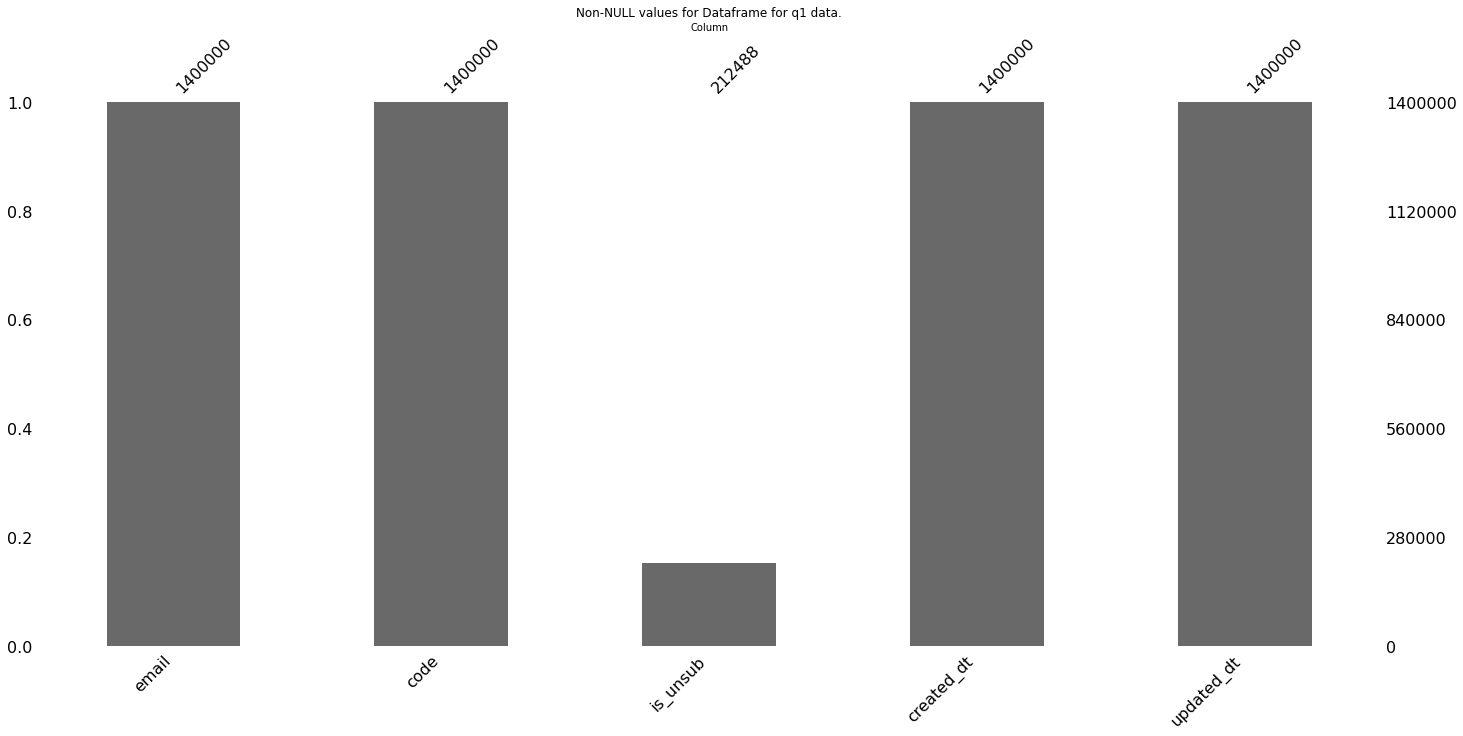

<Figure size 360x144 with 0 Axes>

In [55]:
check_df_missing_data(df_q1, "Dataframe for q1")

Note: The left join on emails to subcription status created NULL values in the `in_unsub` column.

Because the second question does not specify to remove people who are unsubbed, I will preserve rows with NULL values in the `in_unsub` column. I will mark these values as `unknown`.

In [56]:
missing_col = 'is_unsub'
df_q1[missing_col].fillna("unknown", inplace = True)

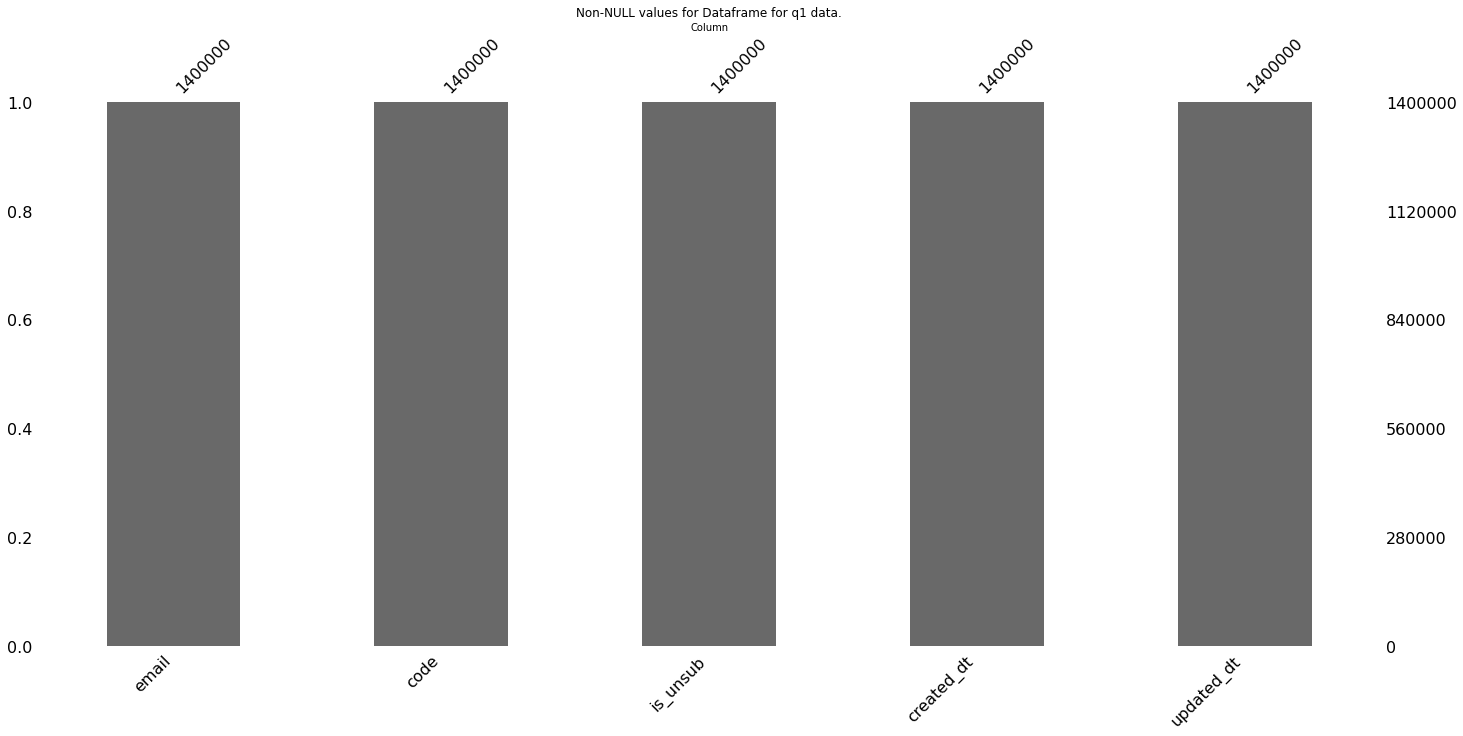

<Figure size 360x144 with 0 Axes>

In [57]:
check_df_missing_data(df_q1, "Dataframe for q1")

In [58]:
file_name = 'people.csv'

df_q1.to_csv(
    path_or_buf = file_name,
    index = False,)

print(f"Wrote dataframe to {file_name}")

Wrote dataframe to people.csv


# Q2: “Acquisition_facts” file with stats about when people where acquired

## Extract date from created_dt
`created_dt` is stored as datetime, however the acquisition_facts scecifications request a date.

In [59]:
df_q1.head()

,email,code,is_unsub,created_dt,updated_dt
0,lucassmith@yahoo.com,google,unknown,1983-08-26 06:02:03,2015-12-27 09:28:02
1,misty66@walsh-hampton.biz,google,unknown,1983-08-26 06:02:03,2015-12-27 09:28:02
2,daniel72@hudson.com,google,unknown,1983-08-26 06:02:03,2015-12-27 09:28:02
3,deborah57@shaffer-reed.org,facebook,1,1979-03-05 21:08:54,1989-06-20 13:28:57
4,asmith@henderson-hill.com,facebook,unknown,1979-03-05 21:08:54,1989-06-20 13:28:57


In [60]:
df_q1['acquired'] = df_q1['created_dt'].dt.date

In [61]:
df_q1.head()

,email,code,is_unsub,created_dt,updated_dt,acquired
0,lucassmith@yahoo.com,google,unknown,1983-08-26 06:02:03,2015-12-27 09:28:02,1983-08-26
1,misty66@walsh-hampton.biz,google,unknown,1983-08-26 06:02:03,2015-12-27 09:28:02,1983-08-26
2,daniel72@hudson.com,google,unknown,1983-08-26 06:02:03,2015-12-27 09:28:02,1983-08-26
3,deborah57@shaffer-reed.org,facebook,1,1979-03-05 21:08:54,1989-06-20 13:28:57,1979-03-05
4,asmith@henderson-hill.com,facebook,unknown,1979-03-05 21:08:54,1989-06-20 13:28:57,1979-03-05


## Group values by date
This section creates a dataframe with count values for each acquired date.

In [62]:
group_var = ['acquired']

df_q2 = (
    df_q1
    .groupby( group_var, as_index = True)
    .count()
    .sort_values(group_var, ascending = True)['email']
    .reset_index()
)


df_q2.head()

,acquired,email
0,1970-01-01,64
1,1970-01-02,64
2,1970-01-03,74
3,1970-01-04,83
4,1970-01-05,85


Note: date starts at Epoch time - likely reflects the fake data.

In [63]:
print(len(df_q2))

18445


## Write to csv

In [64]:
file_name = "acquisition_facts.csv"

df_q2.to_csv(
    path_or_buf = file_name,
    index = False
)
print(f"Wrote dataframe to {file_name}")

Wrote dataframe to acquisition_facts.csv
